In [1]:
import numpy as np
from scipy import spatial 
import faiss
import typing
from time import time
import matplotlib.pyplot as plt


## Helper Function

In [2]:
def generate_vectors(
        num_vectors: int,
        dim: int,
        distribution: str,
        seed: int = 42,
) -> np.ndarray:
    """
    This function generates random vectors of uniform distribution.
    Args:
        num_vectors: The number of vectors to generate.
        dim: The dimensionality of the vectors.
        seed: The random seed.
    Returns:
        An array of shape (num_vectors, dim) containing the generated vectors.
    """
    np.random.seed(seed)
    return np.random.uniform(0, 1, (num_vectors, dim))

In [3]:
def naive_exhaustive_search(
        query_vectors: np.ndarray,
        index_vectors: np.ndarray, 
        k: int,
) -> np.ndarray:
    """
    This function computes the k-nearest neighbors of query_vectors in index_vectors using the naive exhaustive approach.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    all_distances = []
    for query_vector in query_vectors:
        query_distances = []
        for index_vector in index_vectors:
            query_distances.append(spatial.distance.euclidean(query_vector, index_vector))
        all_distances.append(np.argsort(query_distances)[:k])
    return np.array(all_distances)

In [4]:
def optimized_exhaustive_search(
        query_vectors: np.ndarray,
        index_vectors: np.ndarray,
        k: int,
):
    """
    This function computes the k-nearest neighbors of query_vectors in index_vectors using the optimized exhaustive approach implemented in SciPy.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    distances = spatial.distance.cdist(query_vectors, index_vectors, 'euclidean')
    return np.argsort(distances, axis=1)[:, :k]

In [5]:
def build_faiss_flatl2_index(
        index_vectors: np.ndarray,
        dim: int,
):
    """
    This function builds a Faiss flat L2 index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
    Returns:
        A Faiss flat L2 index.
    """
    index = faiss.IndexFlatL2(dim)
    index.add(index_vectors)
    return index

In [6]:
def faiss_search(
        query_vectors: np.ndarray,
        index: faiss.Index,
        k: int,
):
    """
    This function uses a Faiss index to search for the k-nearest neighbors of query_vectors.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        index: A Faiss index.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    distances, indices = index.search(query_vectors, k)
    return indices

In [7]:
def build_faiss_lsh_index(
        index_vectors: np.ndarray,
        dim: int,
        nbits: int,
):
    """
    This function builds a Faiss LSH index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
        nbits: The number of bits to use in the hash.
    Returns:
        A Faiss LSH index.
    """
    index = faiss.IndexLSH(dim, nbits)
    index.add(index_vectors)
    return index

In [8]:
def compute_recall_at_k(
        nn_gt: np.ndarray,
        ann: np.ndarray,
        k: int,
):
    """
    This function computes the recall@k.
    Args:
        nn_gt: The ground truth nearest neighbors.
        ann: The approximate nearest neighbors.
        k: The number of nearest neighbors to consider.
    Returns:
        The recall@k.
    """
    return round(sum([len(set(ann[i]) & set(nn_gt[i])) / k for i in range(len(ann))])/len(ann), 3)

# 1.1 - Running Time Comparison

You are given three methods for vector search:
<ol>
 <li> naive_exhaustive_search </li> 
 <li> optimized_exhaustive_search </li> 
 <li> faiss_flatL2 </li> 
</ol>

each one implements vector search with different levels of optimization. Your task is to compare the running time of these three methods. 
You need to complete the code so that the generated plots should reflect the increasing difference in running time between the methods, as a function of the desired parameters.
The plots should be clear and self-explanatory, including the labels, title, and legend.
There is no need to experiment with long running times (few seconds are enough for each plot); just ensure that the trends are visible.
You are allowed to add more cells between the TODOs, but do not flip the order of the subsections.
When you finish. do not forget to attach the plots to report.pdf, placed under a clear title indicating the section number.

### Generate the following plots:
##### 1.1.1. Running time of the three methods as a function of the number of vectors in the index (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
##### 1.1.2. Running time of methods 2 and 3 (optimized_exhaustive_search and faiss_flatL2) as a function of the dimensionality of the vectors (x-axis) with the following parameters fixed:
* number of vectors in the index: 100000
* number of vectors in the query set: 100

index size=100, naive_time=1.842994213104248, optimized_time=0.021001577377319336, faiss_time=0.11099743843078613
index size=200, naive_time=3.469000816345215, optimized_time=0.04400300979614258, faiss_time=0.004995822906494141
index size=300, naive_time=4.102000951766968, optimized_time=0.044004201889038086, faiss_time=0.0019953250885009766
index size=400, naive_time=4.347339391708374, optimized_time=0.05700349807739258, faiss_time=0.0049970149993896484
index size=500, naive_time=5.621494293212891, optimized_time=0.06200051307678223, faiss_time=0.003000020980834961
index size=600, naive_time=10.336190938949585, optimized_time=0.1562650203704834, faiss_time=0.015017271041870117
index size=700, naive_time=9.128319025039673, optimized_time=0.10100030899047852, faiss_time=0.0039997100830078125
index size=800, naive_time=13.571632623672485, optimized_time=0.22400188446044922, faiss_time=0.00899815559387207
index size=900, naive_time=17.33463144302368, optimized_time=0.24100136756896973, fa

Text(0, 0.5, 'Running time log scale')

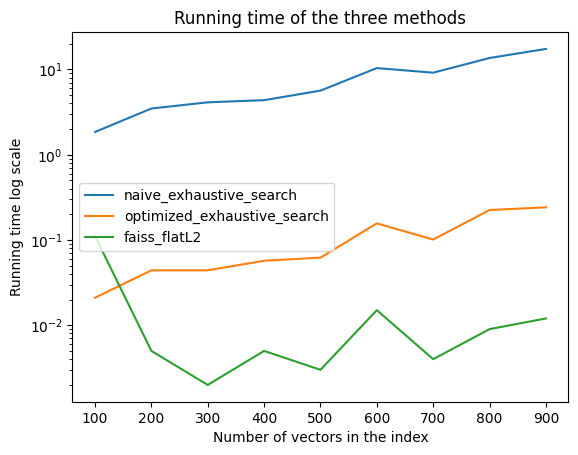

In [9]:
#TODO Write your code for 1.1.1 here
# first we will generate the data for the plots
query_vectors = generate_vectors(1000, 100, 'uniform')
naive_time_array=[]
optimized_time_array=[]
faiss_time_array=[]
index_size_array=np.arange(100,1000,100)
# for a changing value of index vector  we will compute the running time of the three methods
for count in index_size_array:
    indexs=generate_vectors(count, 100, 'uniform')
    start_time= time()
    naive_vecs= naive_exhaustive_search(query_vectors, indexs, k=10)
    naive_time = time()-start_time
    start_time= time()
    optimized_vecs = optimized_exhaustive_search(query_vectors,indexs, k=10)
    optimized_time = time()-start_time
    start_time= time()
    faiss_index = build_faiss_flatl2_index(indexs, 100)
    faiss_vecs = faiss_search(query_vectors, faiss_index, k=10)
    faiss_time = time()-start_time
    print(f'index size={count}, naive_time={naive_time}, optimized_time={optimized_time}, faiss_time={faiss_time}')
    naive_time_array.append(naive_time)
    optimized_time_array.append(optimized_time)
    faiss_time_array.append(faiss_time)

#make plots for every method
plt.plot(index_size_array,naive_time_array, label='naive_exhaustive_search')
plt.plot(index_size_array,optimized_time_array, label='optimized_exhaustive_search')
plt.plot(index_size_array,faiss_time_array, label='faiss_flatL2')
plt.title("Running time of the three methods")
plt.legend()
plt.yscale('log')
plt.xlabel('Number of vectors in the index')
plt.ylabel('Running time log scale')


dim size=100, optimized_time=3.284994125366211, faiss_time=0.08400321006774902
dim size=150, optimized_time=3.8439950942993164, faiss_time=0.19400262832641602
dim size=200, optimized_time=4.351999759674072, faiss_time=0.25099921226501465
dim size=250, optimized_time=4.66303277015686, faiss_time=0.17696762084960938
dim size=300, optimized_time=6.208591938018799, faiss_time=0.6299993991851807
dim size=350, optimized_time=7.365883827209473, faiss_time=0.8830621242523193
dim size=400, optimized_time=8.74496078491211, faiss_time=0.5700018405914307
dim size=450, optimized_time=10.895999908447266, faiss_time=0.6890029907226562
dim size=500, optimized_time=13.676034212112427, faiss_time=2.340998649597168
dim size=550, optimized_time=11.097023963928223, faiss_time=0.5769784450531006
dim size=600, optimized_time=14.515069484710693, faiss_time=0.9265346527099609
dim size=650, optimized_time=18.231647491455078, faiss_time=2.9690425395965576
dim size=700, optimized_time=16.452998638153076, faiss_ti

Text(0, 0.5, 'Running time')

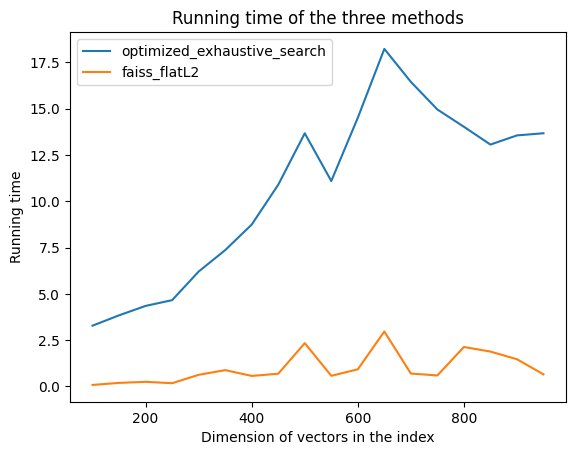

In [10]:
#TODO Write your code for 1.1.2 here
optimized_time_array=[]
faiss_time_array=[]
dim_array=np.arange(100,1000,50)

for dim in dim_array:
    query_vectors = generate_vectors(100, dim, 'uniform')
    indexs=generate_vectors(100000, dim, 'uniform')
    start_time= time()
    optimized_vecs = optimized_exhaustive_search(query_vectors,indexs, k=10)
    optimized_time = time()-start_time
    start_time= time()
    faiss_index = build_faiss_flatl2_index(indexs, int(dim))
    faiss_vecs = faiss_search(query_vectors, faiss_index, k=10)
    faiss_time = time()-start_time
    print(f'dim size={dim}, optimized_time={optimized_time}, faiss_time={faiss_time}')
    optimized_time_array.append(optimized_time)
    faiss_time_array.append(faiss_time)

#make plots for every method
plt.plot(dim_array,optimized_time_array, label='optimized_exhaustive_search')
plt.plot(dim_array,faiss_time_array, label='faiss_flatL2')
plt.title("Running time of the three methods")
plt.legend()
plt.xlabel('Dimension of vectors in the index')
plt.ylabel('Running time')


# 1.2 -- Faiss LSH
### Create the following plots:
##### 1.2.1. Running time of Faiss LSH as a function of the number of vectors in the index (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
* nbits: 500

##### 1.2.2. Running time of Faiss LSH as a function of nbits (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
* number of vectors in the index: 500000


##### 1.2.3. recall@k of Faiss LSH as a function of nbits (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 100
* number of vectors in the index: 100000
* k: 10


You need to complete the code so that the generated plots should reflect the desired metrics as a function of the desired parameters.
The plots should be clear and self-explanatory, including the labels, title, and legend.
There is no need to experiment with long running times (few seconds are enough for each plot); just ensure that the trends are visible.
You are allowed to add more cells between the TODOs, but do not flip the order of the subsections.
When you finish. do not forget to attach the plots to report.pdf, placed under a clear title indicating the section number.


index size=10000, lsh_time=0.17799997329711914
index size=20000, lsh_time=0.19700074195861816
index size=30000, lsh_time=0.38300228118896484
index size=40000, lsh_time=0.2479560375213623
index size=50000, lsh_time=0.3549811840057373
index size=60000, lsh_time=0.37599968910217285
index size=70000, lsh_time=0.48200273513793945
index size=80000, lsh_time=0.49100160598754883
index size=90000, lsh_time=0.5400009155273438


Text(0, 0.5, 'Running time')

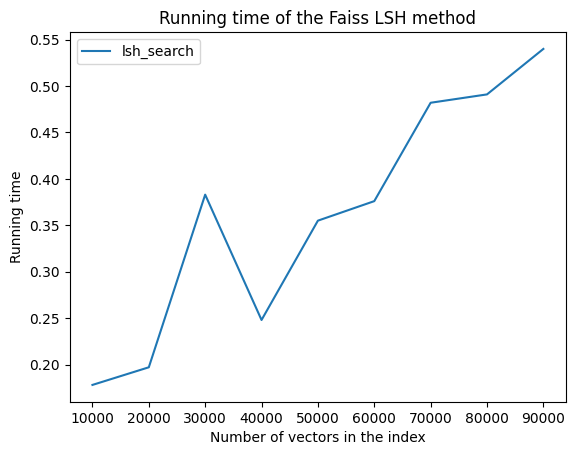

In [11]:
#TODO: Write your code for 1.2.1 here

lsh_time_array=[]
vec_num_array=np.arange(10000,100000,10000)
query_vectors = generate_vectors(1000, 100, 'uniform')

for count in vec_num_array:
    index_vectors=generate_vectors(count, 100, 'uniform')
    start_time= time()
    lsh_indexes = build_faiss_lsh_index(index_vectors, 100, 500)
    faiss_vecs = faiss_search(query_vectors, lsh_indexes, k=10)
    lsh_time = time()-start_time
    print(f'index size={count}, lsh_time={lsh_time}')
    lsh_time_array.append(lsh_time)

#make plots for every method
plt.plot(vec_num_array,lsh_time_array, label='lsh_search')
plt.title("Running time of the Faiss LSH method")
plt.legend()
plt.xlabel('Number of vectors in the index')
plt.ylabel('Running time')


nbit size=50, lsh_time=1.5190043449401855
nbit size=60, lsh_time=0.6720037460327148
nbit size=70, lsh_time=1.3289985656738281
nbit size=80, lsh_time=1.1465208530426025
nbit size=90, lsh_time=1.2283039093017578


Text(0, 0.5, 'Running time')

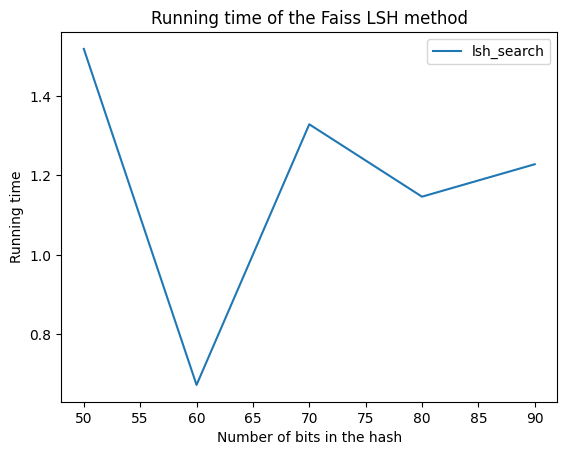

In [12]:
#TODO: Write your code for 1.2.2 here

lsh_time_array=[]
nbit_num_array=np.arange(50,100,10)
query_vectors = generate_vectors(1000, 100, 'uniform')
index_vectors=generate_vectors(500000, 100, 'uniform')

for nbit in nbit_num_array:
    start_time= time()
    lsh_indexes = build_faiss_lsh_index(index_vectors, 100, int(nbit))
    faiss_vecs = faiss_search(query_vectors, lsh_indexes, k=10)
    lsh_time = time()-start_time
    print(f'nbit size={nbit}, lsh_time={lsh_time}')
    lsh_time_array.append(lsh_time)

#make plots for every method
plt.plot(nbit_num_array,lsh_time_array, label='lsh_search')
plt.title("Running time of the Faiss LSH method")
plt.legend()
plt.xlabel('Number of bits in the hash')
plt.ylabel('Running time')


nbit size=100
nbit size=150
nbit size=200
nbit size=250
nbit size=300
nbit size=350
nbit size=400
nbit size=450
nbit size=500
nbit size=550
nbit size=600
nbit size=650
nbit size=700
nbit size=750
nbit size=800
nbit size=850
nbit size=900
nbit size=950


Text(0, 0.5, 'Recall at 10')

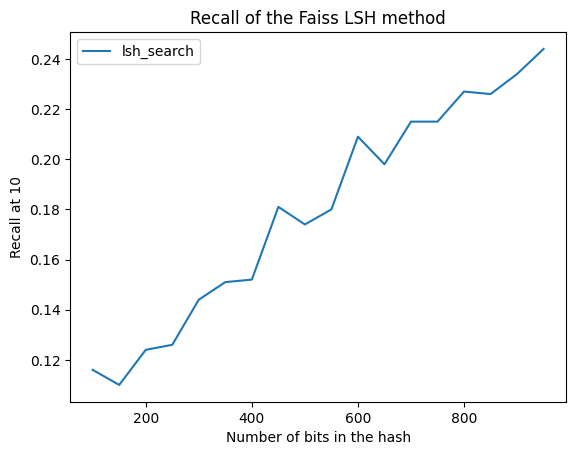

In [13]:
#TODO: Write your code for 1.2.3 here

recall_array=[]
nbit_num_array=np.arange(100,1000,50)
query_vectors = generate_vectors(100, 100, 'uniform')
index_vectors=generate_vectors(100000, 100, 'uniform')
true_labels= optimized_exhaustive_search(query_vectors,index_vectors, k=10)
for nbit in nbit_num_array:
    lsh_indexes = build_faiss_lsh_index(index_vectors, 100, int(nbit))
    faiss_vecs = faiss_search(query_vectors, lsh_indexes, k=10)
    recall_array.append(compute_recall_at_k(true_labels, faiss_vecs, k=10))
    print(f'nbit size={nbit}')

#make plots for every method
plt.plot(nbit_num_array,recall_array, label='lsh_search')
plt.title("Recall of the Faiss LSH method")
plt.legend()
plt.xlabel('Number of bits in the hash')
plt.ylabel('Recall at 10')

